<a href="https://colab.research.google.com/github/iceman011/mydeeplearning/blob/master/ez-mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import time
from datetime import datetime
import os
import pdb

import matplotlib.pyplot as plt
%matplotlib inline

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from google.colab import drive

class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers,output_classes,transform,dataset, drop_p=0.5,lr =0.001, train_on_gpu=False):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        if train_on_gpu:
          # check if CUDA is available
          self.train_on_gpu = torch.cuda.is_available()

        if not self.train_on_gpu:
            print('CUDA is not available.  Using CPU ...')
        else:
            print('CUDA is available!  Using GPU ...')
            
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = lr
        self.output_classes = output_classes
        self.transform=transform
        self.dataset=dataset

        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, validationloader, criterion):
    accuracy = 0
    validation_loss = 0

    print('Starting Validation....')

    with torch.no_grad():    
      # move tensors to GPU if CUDA is available
      if model.train_on_gpu:
        model.cuda()

      for images, labels in validationloader:

          if model.train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
          
          images = images.resize_(images.size()[0], model.input_size)

          output = model.forward(images)
          validation_loss += criterion(output, labels).item()

          ## Calculating the accuracy 
          # Model's output is log-softmax, take exponential to get the probabilities
          ps = torch.exp(output)
          # Class with highest probability is our predicted class, compare with true label
          #equality = (labels.data == ps.max(1)[1])
          # Accuracy is number of correct predictions divided by all predictions, just take the mean
          #accuracy += equality.type_as(torch.FloatTensor()).mean()


        
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))      
        
      validation_loss = validation_loss/len(validationloader)
      accuracy = 100. * accuracy/len(validationloader)
    
    print('Finished Validation ...')
    return validation_loss, accuracy

#############################
# TEST MODEL
############################
def test(model,test_loader,criterion,checkpoint,outputfilepath,batch_size,override_checkpoint):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(model.output_size))
    class_total = list(0. for i in range(model.output_size))

    print('Starting Testing....')
    # move tensors to GPU if CUDA is available
    if model.train_on_gpu:
      model.cuda()

    with torch.no_grad():    
      model.eval()
      # iterate over test data
      for data, target in test_loader:
          # move tensors to GPU if CUDA is available
          if model.train_on_gpu:
              data, target = data.cuda(), target.cuda()
          
          # Flatten images into a 784 long vector
          data.resize_(data.size()[0], model.input_size)

          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # update test loss 
          test_loss += loss.item()*data.size(0)
          # convert output probabilities to predicted class
          _, pred = torch.max(output, 1)    
          # compare predictions to true label
          correct_tensor = pred.eq(target.data.view_as(pred))
          correct = np.squeeze(correct_tensor.numpy()) if not model.train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
          # calculate test accuracy for each object class
          for i in range(batch_size):
              label = target.data[i]
              class_correct[label] += correct[i].item()
              class_total[label] += 1

      # average test loss
      print('Finished Testing ...')
      test_loss = test_loss/len(test_loader.dataset)
      print('Test Loss: {:.6f}\n'.format(test_loss))
      
      test_checkpoint = dict()

      if(override_checkpoint):
        checkpoint.update({'TestLoss': test_loss})
      else :
        test_checkpoint.update({'TestLoss': test_loss})

      for i in range(model.output_size):
          if class_total[i] > 0:
            current_key  = 'Test Accuracy of '+model.output_classes[i]
            current_val = '{:.3f}% ({}/{})'.format(100 *( class_correct[i] / class_total[i]),
                  np.sum(class_correct[i]), np.sum(class_total[i]))
            ele={current_key:current_val}
            if(override_checkpoint):
              checkpoint.update(ele)
              print(current_key,current_val)
            else:
              test_checkpoint.update(ele)


          """else:
              print('Test Accuracy of %5s: N/A (no training examples)' % (model.output_classes[i]))
          """

      current_key = 'Test Accuracy (Overall): '#.format(100. * np.sum(class_correct) / np.sum(class_total))
      current_val = '{:.3f}% ({}/{})'.format(100 * (np.sum(class_correct) / np.sum(class_total)),
          np.sum(class_correct), np.sum(class_total) )
      ele={current_key:current_val}
      if(override_checkpoint):
        checkpoint.update(ele)      
        print(current_key,current_val)
      else:
        test_checkpoint.update(ele)
        test_checkpoint.update({'Detailed ':checkpoint})

    
    #model.train()
    if(override_checkpoint):
      print('Overriding Checkpoint')
      torch.save(checkpoint,outputfilepath)

    return checkpoint , test_checkpoint

#############################
# TRAIN MODEL
############################
def train(model, trainloader, validationloader, criterion, optimizer, uploadToGDrive,epochs=5, print_every=40):
    # monitor training loss    
    steps = 0    
    start_time = time.time()
    dateTimeObj = datetime.now()
    #start_time_timestamp = './results/'+dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
    start_time_timestamp = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
    train_losses, valid_losses = [], []
    
    # move tensors to GPU if CUDA is available
    if model.train_on_gpu:
      model.cuda()

    print('Starting Training using Model Parameters \n',model )
    valid_loss_min = np.Inf # set initial "min" to infinity
    
    for e in range(epochs):        
        train_loss = 0.0
        valid_loss = 0.0


        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for images, labels in trainloader:
            steps += 1
            
            # move tensors to GPU if CUDA is available
            if model.train_on_gpu:
              images, labels = images.cuda(), labels.cuda()

            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], model.input_size)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        train_loss = train_loss/len(trainloader.sampler)
        train_losses.append(train_loss)
        ######################    
        # validate the model #
        ######################
        # Model in inference mode, dropout is off
        model.eval()
        
        print('Finished Training of Epoch '+str(e))

        # Turn off gradients for validation, will speed up inference
        with torch.no_grad():
            valid_loss, accuracy = validation(model, validationloader, criterion)
        
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy : {:.6f}'.format(
            e+1, 
            train_loss,
            valid_loss,
            accuracy
            ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f} ,)  Accuracy: {:.6f}  TimeElapsed: {:.6f}.  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            accuracy,
            (time.time() - start_time)))
              
            checkpoint = {'InputSize': model.input_size,
                  'OutputSize': model.output_size,
                  'HiddenLayers': [each.out_features for each in model.hidden_layers],
                  'LearningRate':model.learning_rate,
                  'TrainingLoss' :train_loss,
                  'ValidationLoss':valid_loss,
                  'ValidationAccuracy':accuracy,
                  'ElapsedTime': (time.time() - start_time),
                  'Dataset':model.dataset,
                  'LastEpoch': e,
                  'GPUState': model.train_on_gpu,                  
                  'OutputFolder' : start_time_timestamp,
                  'CheckPointTimestamp': time.time(),
                  'OutputFilePrefix' : 'checkpoint_',
                  'OutputClasses': model.output_classes,
                  'Transforms': model.transform,
                  'TrainingLosses' :train_losses,
                  'ValidationLosses':valid_losses,
                  'StateDictionay': model.state_dict()}
            
            #print(checkpoint)
            save_model(checkpoint,uploadToGDrive)
            """ if not os.path.exists(start_time_timestamp):
                os.makedirs(start_time_timestamp)
                
            torch.save(checkpoint, './'+start_time_timestamp+'/checkpoint_'+str(e)+'.pt')
            """
            valid_loss_min = valid_loss

    return train_losses , valid_losses , checkpoint


#############################
# SAVE MODEL TO GOOGLE DRIVE
############################
def save_model(checkpoint,uploadToGDrive):
  
  if(uploadToGDrive):
    drive.mount('/content/gdrive')
    path = f'/content/gdrive/My Drive/Colab Notebooks/models/minst/'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch'])+'.pt'
    torch.save(checkpoint, path)
  else:
    if not os.path.exists(checkpoint['OutputFolder']):
      os.makedirs(checkpoint['OutputFolder'])      
    torch.save(checkpoint, './'+checkpoint['OutputFolder']+'/'+str(checkpoint['LastEpoch'])+'.pt')

#############################
# PLOT TRAINING LOSS VS VALIDATION LOSS 
############################
def plotLossTrend(train_losses,validation_losses,test_losses=[]):
  #TRAINING LOSS DATA
  values = []
  labels = []
  for item in train_losses:    
    for key, value in item.items():
      #pdb.set_trace()
      values.append("{0:.2f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']


  plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Training Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  #plt.show()

  #VALIDATON LOSS
  values = []
  labels = []
  for item in validation_losses:   
    #pdb.set_trace() 
    for key, value in item.items():      
      values.append("{0:.2f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']


  #plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Validation Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  #plt.show()

  #TEST LOSS
  values = []
  labels = []
  for item in test_losses:    
    for key, value in item.items():
      #pdb.set_trace()
      values.append("{0:.2f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']


  #plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Test Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  plt.show()
  #for i, v in enumerate(values):
  #    ax.text(i, v+25, "%d" %v, ha="center")
  #plt.ylim(-10, 595)


#############################
# LOAD CHECKPOINT
############################
def load_checkpoint(OutputFolder,OutputFilePrefix,max_epoch,exact_epoch):
    
    file_epoch = 0
    if(max_epoch):
      for filename in os.listdir(OutputFolder):
        data = filename.split('_')
        tmp=int(data[1][:-3])
        #print('data[1]',data[1],' tmp[:-3] ',tmp[:-3])
        if( file_epoch <= tmp ):
          file_epoch = tmp
    else:
      file_epoch=exact_epoch

    filepath = OutputFolder+'/'+OutputFilePrefix + str(file_epoch)+'.pt'
    
    print('Loading Checkpoint ...')
    indent=1
    checkpoint = torch.load(filepath)
    for key, value in checkpoint.items():
        if(key == 'StateDictionay'):
          continue
        print('\t' * indent + str(key),'\t' * (indent+1) + str(value))
        #print('\t' * (indent+1) + str(value))

    testmodel = Network(checkpoint['InputSize'],
                             checkpoint['OutputSize'],
                             checkpoint['HiddenLayers'],
                            checkpoint['OutputClasses'],
                            checkpoint['Transforms'],
                            checkpoint['Dataset'],
                            lr=checkpoint['LearningRate'],
                            train_on_gpu=checkpoint['GPUState']
                    )
    testmodel.load_state_dict(checkpoint['StateDictionay'])
    return testmodel , checkpoint , filepath

def test_all_epochs(test_loader,criterion,batch_size,OutputFilePrefix='checkpoint_'):

    OutputFolder = './results/'
    file_epoch = 0
    result_list=[]
    print('Starting Test All Saved Epochs ....')
    trainig_loss=[]
    validation_loss=[]
    test_loss=[]
    ele = dict()

    for folder in os.listdir(OutputFolder):
      for filename in os.listdir(OutputFolder+folder):
        data = filename.split('_')
        file_epoch=int(data[1][:-3])

        model , checkpoint , filepath = load_checkpoint(OutputFolder+folder,OutputFilePrefix,False,file_epoch)
        checkpoint , checkpoint_test = test(model,test_loader,criterion,checkpoint,filepath,batch_size,False)

        result_list.append(checkpoint_test)

        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint['TrainingLoss'])
        key = checkpoint['Dataset'] + '_' + checkpoint['OutputFolder'] + '_' + str(checkpoint['LastEpoch'])
        ele = {key: checkpoint['TrainingLoss']}
        trainig_loss.append(ele)
        
        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint['ValidationLoss'])
        ele = {}
        ele ={key: checkpoint['ValidationLoss']}
        validation_loss.append(ele)

        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint_test['TestLoss'])
        ele = {}
        ele ={key: checkpoint_test['TestLoss']}
        test_loss.append(ele)
    
    #print('Result List',result_list)
    plotLossTrend (trainig_loss,validation_loss,test_loss)
    return result_list
      

#############################
# VISUALIZE ALL IMAGES IN BATCH
############################
def visualize_images_in_batch(loader,batch_size) :
    # obtain one batch of training images
		dataiter = iter(loader)
		images, labels = dataiter.next()
		images = images.numpy()

		# plot the images in the batch, along with the corresponding labels
		fig = plt.figure(figsize=(25, 4))
		for idx in np.arange(batch_size):
			ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
			ax.imshow(np.squeeze(images[idx]), cmap='gray')
			# print out the correct label for each image
			# .item() gets the value contained in a Tensor
			ax.set_title(str(labels[idx].item()))
		return images


#############################
# VISUALIZE PIXEL OF AN IMAGE RETURN FROM PREV FUNCTION
############################
def visualize_image_pixels_value(image):

  img = np.squeeze(image)
  fig = plt.figure(figsize = (12,12)) 
  ax = fig.add_subplot(111)
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
      for y in range(height):
          val = round(img[x][y],2) if img[x][y] !=0 else 0
          ax.annotate(str(val), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center',
                      color='white' if img[x][y]<thresh else 'black')

def visualize_rgb_image_pixels_value(image):
  rgb_img = np.squeeze(image)
  channels = ['red channel', 'green channel', 'blue channel']

  fig = plt.figure(figsize = (36, 36)) 
  for idx in np.arange(rgb_img.shape[0]):
      ax = fig.add_subplot(1, 3, idx + 1)
      img = rgb_img[idx]
      ax.imshow(img, cmap='gray')
      ax.set_title(channels[idx])
      width, height = img.shape
      thresh = img.max()/2.5
      for x in range(width):
          for y in range(height):
              val = round(img[x][y],2) if img[x][y] !=0 else 0
              ax.annotate(str(val), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center', size=8,
                      color='white' if img[x][y]<thresh else 'black')

def visualize_test_results(model,test_loader,batch_size,RGB=False):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images.numpy()

  # move model inputs to cuda, if GPU available
  if model.train_on_gpu:
      images = images.cuda()

  # Flatten images into a 784 long vector
  images.resize_(images.size()[0], model.input_size)

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not model.train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(batch_size):
      ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])

      image_cpu = images.cpu()[idx]
      image_cpu = image_cpu / 2 + 0.5  # unnormalize
      if(RGB):
        plt.imshow(np.transpose(image_cpu, (1, 2, 0)))  # convert from Tensor image
      else:
        ax.imshow(np.squeeze(image_cpu), cmap='gray')

      ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                  color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
######################    
# LOADING DATA #
######################

# import libraries
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def LoadData(datasetName,batch_size=20,valid_size = 0.2):
      
    # number of subprocesses to use for data loading
    num_workers = 0


    # convert data to torch.FloatTensor
    #transform = transforms.ToTensor()

    # convert data to a normalized torch.FloatTensor
    transform = None
    train_data= None
    test_data=None
    classes=None
    if(datasetName == 'MINST'):
       # convert data to a normalized torch.FloatTensor
      transform = transforms.Compose([
          transforms.RandomHorizontalFlip(), # randomly flip and rotate
          #transforms.RandomRotation(10),
          transforms.CenterCrop(224),          
          transforms.ToTensor(),
          transforms.Normalize((0.5, ), (0.5, ))
          ])
      
      # choose the training and test datasets
      train_data = datasets.MNIST(root='data', train=True,
                                        download=True, transform=transform)
      test_data = datasets.MNIST(root='data', train=False,
                                        download=True, transform=transform)
      # specify the image classes
      classes = ['1', '2', '3', '4', '5',
           '6', '7', '8', '9', '10']
    elif(datasetName == 'CIFAR'):
      
      # convert data to a normalized torch.FloatTensor
      transform = transforms.Compose([
          transforms.RandomHorizontalFlip(), # randomly flip and rotate
          transforms.RandomRotation(10),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])
      
      # choose the training and test datasets
      train_data = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
      test_data = datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=transform)
      # specify the image classes
      classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
        num_workers=num_workers)
    return train_loader , valid_loader ,test_loader ,classes , transform

In [0]:
from torch import optim

######################    
# MAIN #
######################

#How many samples loaded per batch
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

#train_loader =None
#valid_loader =None
#Load Data
dataset = 'MINST'
train_loader , valid_loader ,test_loader , classes , transform = LoadData(dataset,batch_size,valid_size)


# Create the network, define the criterion and optimizer
model = Network(784, 10, [512, 256, 128],classes,transform,dataset, lr=0.001,train_on_gpu=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, True,epochs=100)

#plotLossTrend (train_lossess , valid_lossess)


CUDA is available!  Using GPU ...
Starting Training using Model Parameters 
 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Finished Training of Epoch 0
Starting Validation....
Finished Validation ...
Epoch: 1 	Training Loss: 0.115155 	Validation Loss: 2.301292 	Accuracy : 11.249996
Validation loss decreased (inf --> 2.301292 ,)  Accuracy: 11.249996  TimeElapsed: 26.155153.  Saving model ...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Finished Training of Epoch 1
Starting Validation....
Finished Validation ...
Epoch: 2 	Training Loss: 0.115080 	Validation Loss: 2.301569 	Accuracy : 11.249990
Finished Training of E

In [0]:
images = visualize_images_in_batch(train_loader,batch_size)
visualize_image_pixels_value(images[2])

model , checkpointtt , filepathh = load_checkpoint(checkpointt['OutputFolder'],checkpointt['OutputFilePrefix'],True,0)

checkpointttt = test(model,test_loader,criterion,checkpointtt,filepathh,batch_size,True)

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

#visualize_rgb_image_pixels_value(images[2])
#visualize_test_results(model,test_loader,batch_size)

Starting Test All Saved Epochs ....
Loading Checkpoint ...
	InputSize 		784
	OutputSize 		10
	HiddenLayers 		[512, 256, 128]
	LearningRate 		0.001
	TrainingLoss 		0.03628482920404834
	ValidationLoss 		0.3084243535467734
	ValidationAccuracy 		tensor(90.4751)
	ElapsedTime 		14.150646686553955
	Dataset 		MINST
	LastEpoch 		0
	GPUState 		True
	OutputFolder 		./results/29_Feb_2020_17_50_59
	CheckPointTimestamp 		1582998673.2998638
	OutputFilePrefix 		checkpoint_
	OutputClasses 		['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
	Transforms 		Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
	TrainingLosses 		[0.03628482920404834]
	ValidationLosses 		[0.3084243535467734]
CUDA is available!  Using GPU ...
Starting Testing....
Finished Testing ...
Test Loss: 0.287034

Loading Checkpoint ...
	InputSize 		784
	OutputSize 		10
	HiddenLayers 		[512, 256, 128]
	LearningRate 		0.001
	TrainingLoss 		0.0232516021313689
	ValidationLoss 		0.22873689129327734
	ValidationAccuracy 		tensor

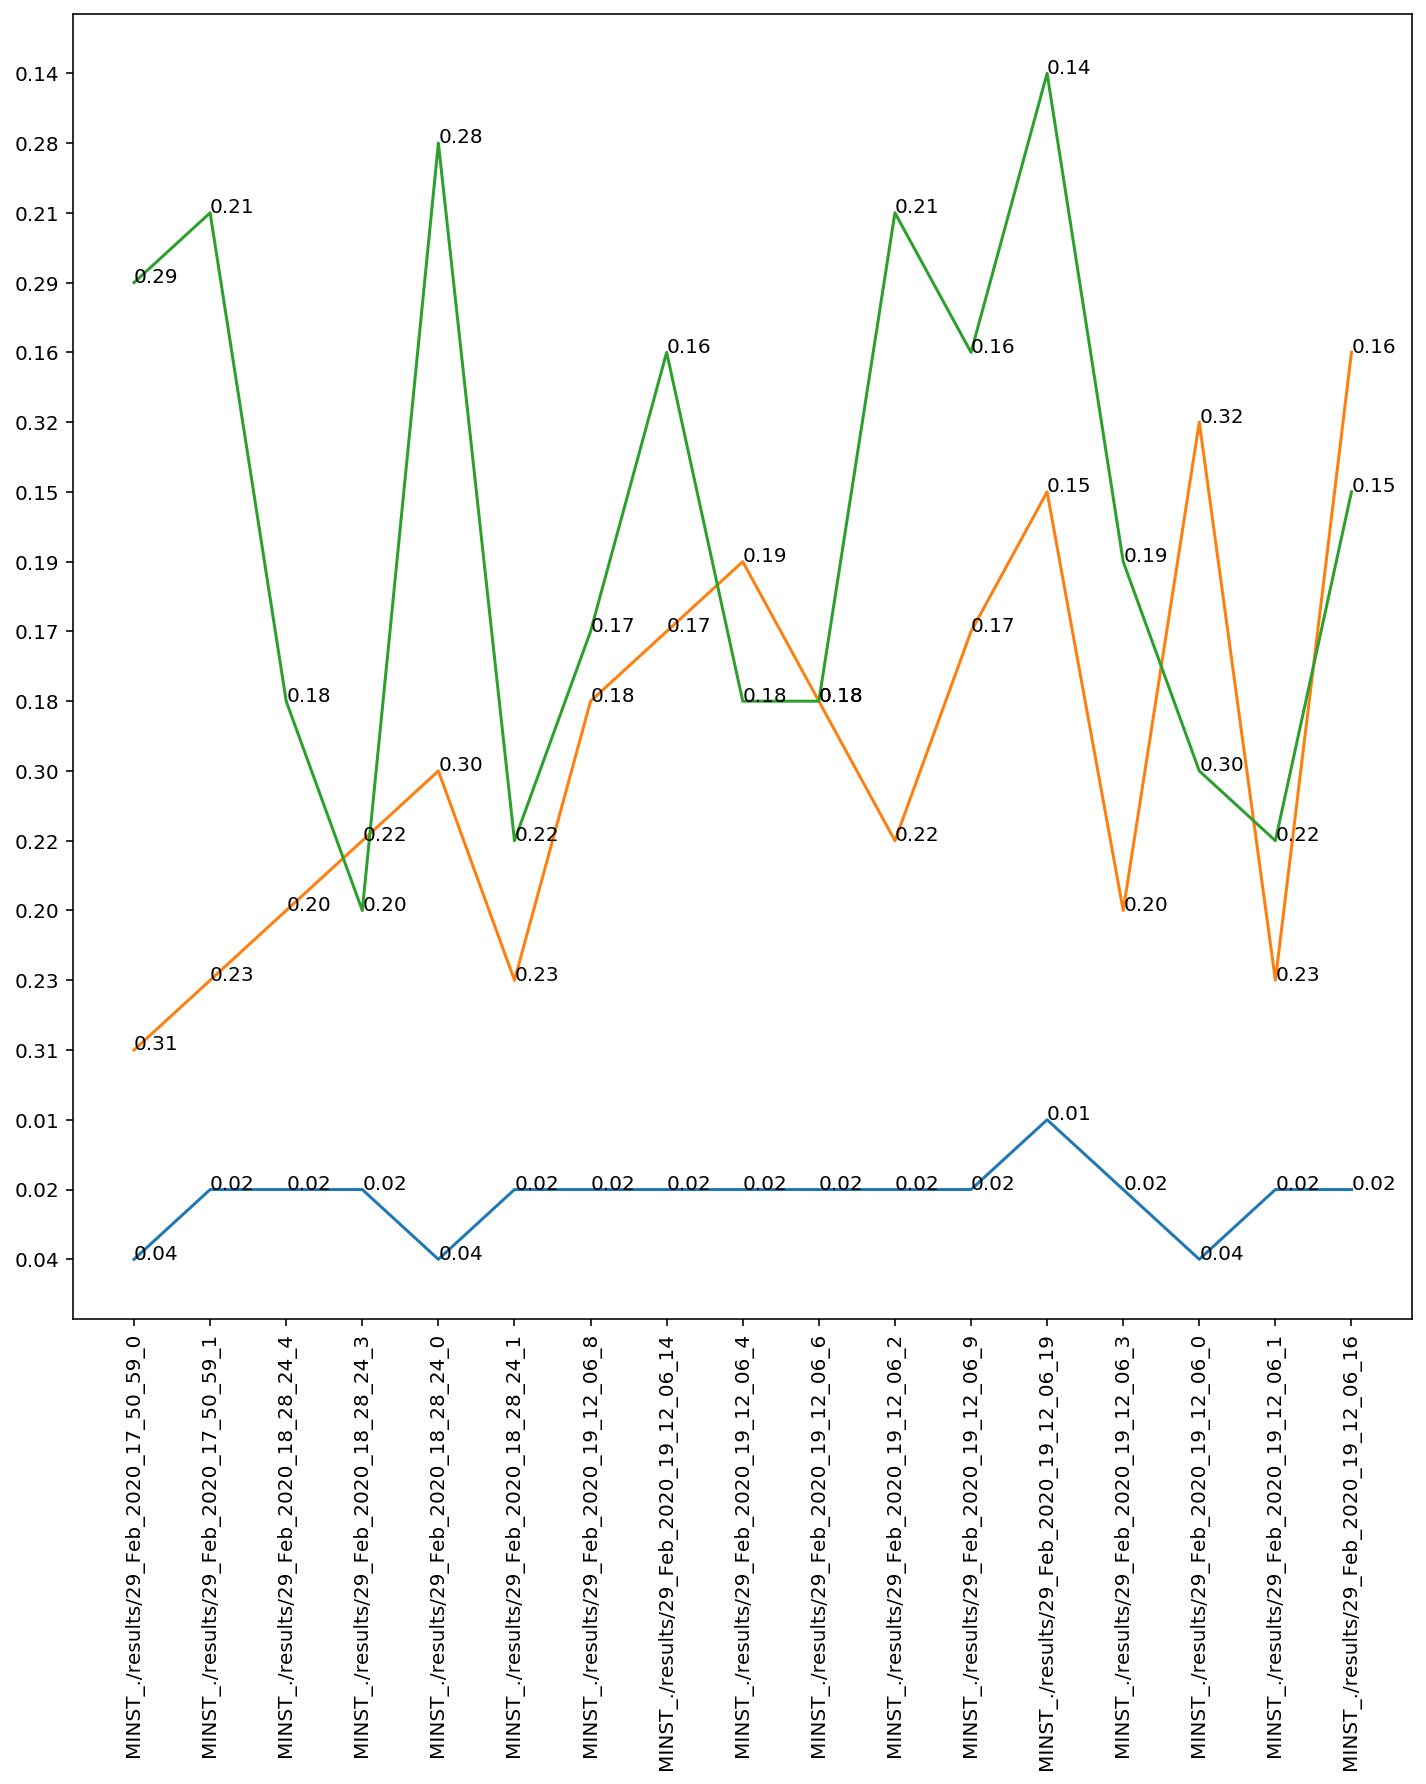

In [75]:
#model , checkpointtt , filepathh = load_checkpoint(checkpointttt['OutputFolder'],checkpointttt['OutputFilePrefix'],False,10)

result_list = test_all_epochs(test_loader,criterion,batch_size)
